![](img/logo.png)


# Máquinas de Soporte Vectorial

> __Alcance de la lectura__
> * Comprender el principio de la maximización del márgen como un clasificador.
> * Diferenciar entre la clasificación estricita y flexible de márgen.
> * Entrenar modelos mediante `Pipelines`.
> * Implementar modelos SVC.
> * Identificar el kernel radial-basis-function y su implementación en SVC.
> * Manipular hiperparámetros mediante la técnica GridSearchCV.

---

## Motivación

Las Máquinas de Soporte Vectorial (de aquí en adelante SVM, _Support Vector Machines_) son modelos con una amplia versatilidad para manejar tareas de clasificación y regresión en casos lineales y no lineales. Una de las principales bondades de SVM es su rápida implementación y buenos resultados predictivos, situándolas entre las mejores técnicas junto a las redes neuronales, ensambles, sistemas de votación y gradient boosting (elementos que veremos posteriormente). Para entender el comportamiento de SVM, Murphy (2012) recalca que es una mezcla entre las técnicas _kernel trick_, _sparsity_ y _large margin principle_. Cada una de éstas mantiene tanto sesgo como varianza controlado en niveles aceptables.


### El caso separable: Clasificadores de Máximo Márgen

Para motivar el uso de SVM, necesitamos estudiar el principio del máximo márgen. Éste surge de la incapacidad de los modelos logísticos de encontrar una frontera de decisión donde los atributos son linealmente separables. La figura izquierda generada con `afx.setup_svm_problem()` demuestra éste problema. La figura presenta una serie de clasificadores lineales, que representan funciones de decisión candidatas para generar una separación eficiente. Lamentablemente algunos de los clasificadores candidatos tienden a acercarse a los atributos en algún rango, lo que imposibilita generar un clasificador óptimo.

SVM ocupa el principio de máximo márgen para encontrar un clasificador lineal óptimo. Este se visualiza en la figura derecha de `afx.setup_svm_problem()`. La obtención del clasificador lineal para este caso implica __maximizar el márgen__ en la distancia entre las dos nubes de datos. Para ello, el algoritmo se vale de los _vectores de soporte_ (encapsulados en un círculo) que establecerán el ancho del márgen, en función al candidato lineal $\beta^{\textsf{T}}+\beta_{0} = 0 $.

El principio del máximo márgen es bastante intuitivo: Si un clasificador tiene una frontera de clasificación demasiado cerca de las instancias de las clases, muy probablemente cuando se agreguen nuevas instancias de datos, algunas de estas caigan del otro lado de la frontera que les corresponde haciendo el clasificador inutil. Por otro lado, si maximizamos la distancia entre las clases y la frontera (el márgen entre las clases), aunque se agreguen más datos estos rara vez se deberían desviar demasiado de los datos ya vistos. Por lo tanto, probablemente estarán dentro de las fronteras correspondientes.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import lec5_graphs as afx
plt.style.use('seaborn')
plt.rcParams['figure.figsize']=(10, 6)

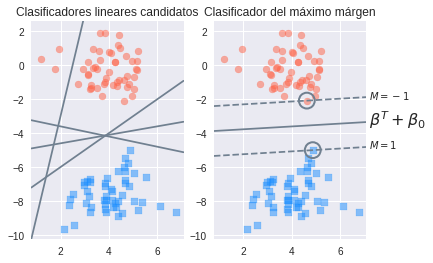

In [2]:
afx.setup_svm_problem()

> #### Digresión: Obtención del plano clasificador en el caso lineal separable
>
 > Si tenemos $N$ observaciones en pares de forma $(x_{1}, y_{2}), \cdots (x_{n}, y_{n})$ donde $x_{i} \in \mathbf{X}^{\mathbb{R}}$ e $y \in \mathbb{Y} \rightarrow \{-1, 1\}$ se busca un hiperplano con la siguiente expresión:
>
>$$
\Big\{x: f(x)=\mathbf{X}^{\mathsf{T}}\beta + \beta_{0} = 0 \Big\}
$$
>
>A partir de este hiperplano buscamos una regla de clasificación
>
>$$
G(x)=\textsf{sign}\Big[\mathbf{X}\beta + \beta_{0}\Big]
$$
>
>donde $G(x)$ da la distancia de $x_{i}$ en el hiperplano.
> Posterior a la obtención de éste candidato, buscamos maximizar la distancia del márgen con la siguiente estrategia de optimización:
>
> $$
\underset{\beta, \beta_0, \vert\vert \beta \vert\vert =1}{\textsf{argmax}} \ M\\
\textsf{Subjeto a: }y_{i}(\mathbf{X}^{\mathsf{T}}\beta + \beta_{0}) \geq M \qquad \forall i \in N
$$
>
> Donde $M$ es el _**márgen**_, en la figura de derecha`afx.setup_svm_problem()` el margen $M$ es la distancia entre cualquiera de las líneas punteadas y la linea central continua que representa la frontera de clasificación.


Éste caso hipotético donde las clases son linealmente separables se conoce como __clasificación estricta de márgen__, dado que la optimización de la función dependerá exclusivamente que dentro del márgen no existan vectores. Otro aspecto a considerar es el hecho que los clasificadores estrictos __son sensibles a outliers__, por lo que la obtención de márgenes en una muestra de entrenamiento con outliers puede conllevar a fallas de generalización del modelo. El principal problema de esta aproximación es que si las clases no son linealmente separables el problema no tiene solución, es decir, nuestro modelo no es capaz de encontrar ningún clasificador.

> #### Digresión: Estandarización de atributos
>
> Para evitar la influencia de outliers en la muestra de entrenamiento, podemos preprocesar los datos mediante `StandardScaler`. También existe la posibilidad de preprocesar los atributos con alguna técnica de reducción de dimensiones como PCA, con la salvedad que SVM hace uso de kernels para reexpresar la dimensionalidad de los datos. Implementar PCA en algunos casos puede forzar linealidad, cosa que no deseamos. Posteriormente hablaremos de los kernels.

El objetivo de SVM es generar un caso de __clasificación flexible de márgen__, donde permitimos encontrar una frontera de decisión optimizada que permita que algunos puntos puedan posicionarse dentro del margen. Este caso da origen a la discusión de las máquinas de soporte vectorial.

### El caso no separable: Máquinas de Soporte Vectorial

Sigamos discutiendo sobre los clasificadores lineales en el contexto de SVM. Resulta que si flexibilizamos nuestra función para aceptar que algunas observaciones se sitúen entre los márgenes, estamos reconociendo que preferimos perder algo de nuestra forma funcional a cambio de una mayor flexibilidad. En la figura `afx.svm_non_separable` graficamos el caso donde permitimos la existencia de observaciones __dentro__ del márgen clasificador. Estos casos se conocen como _slack variables_ (variables de holgura)en la literatura (Vapnik y Cortes, 1996 ; Hastie et al. 2009). En la figura se señalan dos casos de _slacks_:
* ($\xi < 1$) Caso donde la observación se posiciona sobre el márgen de su clase, pero bajo el clasificador lineal. Esta es una situación esperable donde el vector tiene una sobreposición menor al márgen.
* ($\xi > 1$) Caso donde la observación cruza el clasificador lineal y se posiciona en el márgen de la clase contraria. Esta es una situación poco ideal, dado que estamos clasificando de forma errónea la observación.

Resulta que éste último caso sirve como norma para evaluar qué tan bien nuestro modelo disminuye las clasificaciones erróneas (las observaciones $\xi < 1$ siguen siendo clásificadas como azul, sólo que con una menor precisión). Hastie et al. (2009) sugieren que la optimización del márgen debe realizarse considerando $\xi > 1$.

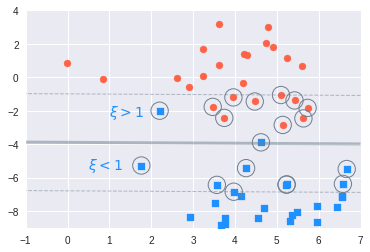

In [3]:
afx.svm_non_separable(plot_slacks=True, plot_xi=True)

Para optimizar la función, consideramos que $\xi_{i}$ representa la proporción en la que una predicción $f(x_{i}) = \beta^{\mathsf{T}} + \beta_{0}$ se posiciona en el lado equivocado del márgen. Mediante ésta flexibilización de la norma, estamos generalizando el funcionamiento de SVM. Cabe destacar que hasta el momento la exposición de SVM se ha desarrollado con un caso canónico: una función lineal. En el ejercicio que desarrollaremos a continuación implementaremos un kernel _radial basis function_, una de las formas más comunes y estudiaremos cómo modificar el márgen mediante hiperparámetros

## Clasificando la calidad de vinos

Aplicaremos nuestra primera Máquina de Soporte Vectorial para clasificar la calidad de vinos dado una serie de atributos fisioquímicas como la acidez, cantidad de sulfatos, porcentaje de alcohol. Los datos del ejemplo vienen de  _P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236._ Partamos por exportar nuestros datos, previamente a la inclusión de los módulos correspondientes.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('winequality_merged.csv').drop(columns='Unnamed: 0')

Generemos una serie de gráficos, donde visualizaremos las distribuciones si las variables son `float` y la frecuencia de ocurrencia si son `integer`. Observamos que en general los atributos se presentan en niveles bajos o moderados. En particular, los atributos que presentan una mayor dispersión en el rango de valores son `alcohol`, `pH` y `total.sulfur.dioxide`.

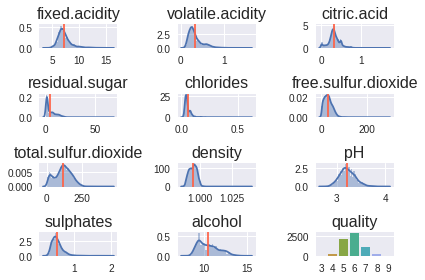

In [5]:
rows = 4; cols = df.shape[1] / rows

for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(rows, cols, index + 1)
    if pd.api.types.is_float_dtype(serie) is True:
        sns.distplot(serie)
        plt.axvline(np.mean(serie), color='tomato')
    elif pd.api.types.is_integer_dtype(serie) is True:
        sns.countplot(serie)
    plt.title(colname, fontsize=16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

Para este ejemplo generaremos una versión binarizada de la calidad de los vinos. Para ello vamos a asignar como 1 todas aquellas observaciones cuya calidad sea superior al promedio, y 0 de lo contrario. Observamos que cerca del 63% de los vinos tuvieron una nota mas alta que el promedio. 

In [6]:
df['quality_bin'] = np.where(df['quality'] > np.mean(df['quality']), 1, 0)
df['quality_bin'].value_counts('%').round(3)

1    0.633
0    0.367
Name: quality_bin, dtype: float64

### Nuestro primer modelo

Para nuestro primer modelo vamos a implementar un kernel lineal, siguiendo el ejemplo expositivo de arriba. Dado que nuestro objetivo es predecir si la clase de una observación es 0 o 1, implementaremos la clase `SVC` del módulo `svm` en la librería `sklearn`. Como se señaló arriba, es importante reescalar los datos para evitar la influencia de outliers, para lo cual importaremos la clase `StandardScaler`. Como en todo flujo de trabajo de modelos de clasificación, importamos las funciones `train_test_split` y `classification_report`. Finalmente importaremos la clase `Pipeline` del módulo `pipeline` de la librería `sklearn` para poder concatenar pasos de ejecución.

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

> #### Digresión: `sklearn` Pipelines
>
> La clase `Pipeline` del módulo `sklearn.pipeline` permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de `scikit-learn`. En sí, la clase cuenta con los métodos clásicos `fit`, `predict` y `score` y presenta un comportamiento idéntico a los demás objetos de `scikit-learn`. Uno de los usos más comunes es para concatenar pasos de preprocesamiento con un modelo.
>
> ##### Componentes de un `Pipeline`
>
> Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de datos, deseo __Estandarlizarlo__, posteriormente __extraer sus principales componentes__ y finalmente __aplicar un modelo de regresión lineal__. Este flujo se puede reexpresar como:
>
> ```python
pipeline_model = Pipeline([('scale', StandardScaler()),
                 ('pca', RandomizedPCA(n_components=3)),
                 ('model', LinearRegression())])
> ```
> Algunos de los elementos a considerar:
> 1. Cada paso se considera como una _tupla_, donde se declara el nombre del paso y la función a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que asociamos el método `StandardScaler` con el string `scale`.
> 2. Todos los pasos declarados se incorporan en una _lista_, donde el orden de ingreso representa el orden de ejecución.
>
> Posteriormente el objeto creado puede utilizarse con los siguientes métodos
> 
> ```python
  pipeline_model.fit(X_train, y_train)
  y_hat = pipeline_model.predict(y_test)
> ```


Una vez que nuestra muestra ya esté dividida en conjuntos de entrenamiento y validación, construiremos nuestro Pipeline. Para nuestro ejemplo, necesitamos concatenar dos pasos:
1. Estandarizar la matriz de atributos en la muestra de entrenamiento mediante `StandardScaler`.
- Generar nuestro modelo SVC (Support Vector Classifier), declarando que implementaremos el kernel lineal.


In [8]:
# Generamos las muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'fixed.acidity':'alcohol'], df['quality_bin'], random_state=11238, test_size=.33)
# Generamos el pipeline
wine_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])

Nuestro objeto `wine_svc` creado con `Pipeline` nos permite trabajar como si fuése cualquier otro método de estimación de `sklearn`, por lo que podemos generar un `fit` en el conjunto de entrenamiento, predecir clases con `predict` utilizando la matriz de atributos de validación y posterior comparación con `clasification_report`. 

In [9]:
wine_svc.fit(X_train, y_train)
y_hat = wine_svc.predict(X_test)
print(classification_report(y_test, y_hat))
# afx.plot_class_report(y_test, y_hat, classes_labels=['Good', 'Bad'])

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       815
           1       0.76      0.85      0.80      1330

   micro avg       0.74      0.74      0.74      2145
   macro avg       0.73      0.71      0.71      2145
weighted avg       0.74      0.74      0.74      2145



A grandes rasgos el modelo tiene un desempeño decente. Obtenemos un 74% de exactitud en nuestras predicciones (medido con el F1, Recall y Precision). Cuando desagregamos por clase, los resultados son distintos. El modelo tiene un buen desempeño para identificar aquellas observaciones que son verdaderamente buenas (etiquetadas con un 1). Respecto a las observaciones como malas, el clasificador presenta una precisión mucho más alta que el recall. Esto sugiere que si bien puede reconocer un mal vino a partir de sus componentes, también falla en reconocer otros vinos que tuvieron un mal ranking en calidad.

### Mejorando nuestro análisis: Kernelización

Hasta el momento hemos trabajado con la versión más "simple" de SVC. Mediante el kernel lineal establecíamos una forma funcional quizás muy estricta que nos esté impidiendo capturar de mejor manera el fenómeno. Para solucionar esto, haremos uso de una de las principales características de las Máquinas de Soporte Vectorial: el poder reexpresar nuestra matriz de atributos en un nuevo espacio que nos permita generar un buen clasificador. Esto se conoce como el principio de Kernelización, a veces referido en la literatura como _Kernel Trick_ o _Kernel-Based Support Vector Machines_.

Para este ejemplo, implementaremos la versión más utilizada: el kernel Gausiano _radial basis function_. Por motivos prácticos de la lectura lo definiremos de forma explícita dentro de la clase, siempre recordando que éste es el kernel por defecto en `SVC` de `sklearn`.

In [10]:
wine_svc_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))
])

wine_svc_rbf.fit(X_train, y_train)
y_hat = wine_svc_rbf.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       815
           1       0.79      0.86      0.82      1330

   micro avg       0.77      0.77      0.77      2145
   macro avg       0.76      0.74      0.74      2145
weighted avg       0.76      0.77      0.76      2145



Tan solo con cambiar nuestro kernel, obtenemos un incremento de 2% en el desempeño de nuestro modelo. De similar manera, las métricas para las clases 0 mejoraron también. Todo esto parece un tanto mágico, ¿qué es lo que pasa cuando decimos las palabras mágicas `kernel='rbf'`?

### ¿Qué es un kernel?

Resulta que cuando nuestro problema no es linealmente separable, necesitamos aplicar una transformación (llámese $\phi(\vec{x})$) en nuestra matriz de atributos para reexpresarlos en un nuevo espacio _donde sí sean linealmente separables_. El kernel `rbf` (Gaussian Radial Basis Function) es una forma de traducir nuestras observaciones en términos de _qué tan similares son entre sí_.
Como su nombre lo indica, busca generar una representación "aproximadamente" similar a la Gaussiana. Para simplificarla, tenemos la siguiente visualización:

![](img/kerneltrick.png)

En la imagen de la izquierda se muestran las coordenadas de dos atributos, con cada clase asignada a un color correspondiente. En esta etapa, no existe un clasificador lineal que pueda separar las clases. El kernel rbf genera una reexpresión de los datos en base a la similitud de atributos. De esta manera, la forma reexpresada de la matriz facilitará la clasificación mediante un hiperplano. Las Máquinas de Soporte Vectorial se han beneficiado de los kernels, aumentando su aplicabilidad en diversos contextos. Dado que los kernels devuelven una representación de los datos en altas dimensiones mediante el producto interno de cada observación, son atractivos al hacer que el modelo se desempeñe de forma eficiente.

__Nota: Cabe destacar que un Kernel en el contexto de SVM no es lo mismo que en los métodos de suavización. Mientras que en éstos últimos hacen referencia a una región específica del espacio de los atributos donde se obtiene un estimado, para las máquinas de soporte vectorial un kernel representa una transformación aplicada al producto interno transpuesto de los atributos__.


 Los métodos de kernel permiten a las funciones operar en altas dimensiones mediante el cálculo del producto interno de cada par de datos en el espacio de atributos.
Se pueden comprender como algoritmos de aprendizaje _basados en instancias_, dado que en vez de aprender un conjunto fijo de parámetros correspondiente a sus atributos, buscan _recordar_ un ejemplo de entrenamiento y estimar un peso asociado. El kernel RBF tiene la siguiente forma funcional:

$$
\kappa(x,x^{\mathsf{T}}) = \textsf{exp}(-\gamma \| x - x^{\mathsf{T}} \|^{2})
$$

Existen otros clásicos kernels que se pueden aplicar:

* Polinomiales de orden-n: $\kappa(x,x^{\mathsf{T}}) = (1 + \langle x, x^{\mathsf{T}} \rangle )^{d} $
* Sigmoide: $\kappa(x, x^{\mathsf{T}}) = \mathsf{tanh}(k_{1} \langle x, x^{\mathsf{T}} \rangle + k_{2})$

#### Digresión: Métodos de Kernel y Kernel Admisible:
> ##### Métodos de Kernel
>  Se dice que un método es un método de kernel si implementa un _kernel trick_, como vimos hasta este punto, la SVM es un método de kernel. Los métodos de kernel son atractivos porque hacen explotar el espacio de atributos facilitando la obtención de espacios linealmente separables. Aunque lo anterior suena divertido y tentador, como mencionamos en algún momento en machine learning nos referimos a un fenómeno que ocurre siempre que tengamos demasiados atributos: La maldición de la dimensionalidad. Uno de los problemas que esta conlleva es que mientras mayor sea el número de atributos, mayor será el espacio de búsqueda (aumenta exponencialmente), las SVM funcionan tan bien porque de cierta forma se blindan de la maldición de la dimensionaldidad a través de la maximización del margen
>
> ##### Kernel Admisible
> Si bien hemos visto y mencionado un par de kernels básicos muy utilizados, el estudio de kernels no se limita solo a estos. Podemos definir nuestros propios kernels siempre y cuando estos cumplan las condiciones de admisibilidad de un kernel (provenientes del Teorema de Mercer). Una vez que se tiene una función que satisfaga admisibilidad de kernel, estamos habilitados para mapear nuestro espacio de atributos como queramos.

## Tercera iteración de análisis: Incorporando hiperparámetros

Existen dos hiperparámetros a considerar cuando estamos entrenando modelos SVM: Costo y $\gamma$. Para visualizar el rango de acción de éstos parámetros generaremos un ejemplo sintético con la _puerta XOR_, que permite visualizar las virtudes del kernel RBF. Un aspecto a considerar es que los datos generados en este ejemplo __no son linealmente separables__ cuando no implementamos un kernel.

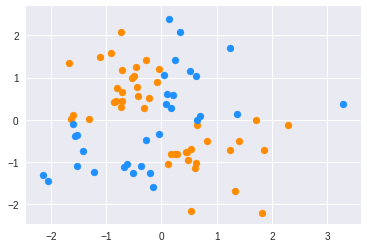

In [11]:
X, y = afx.svm_logical_xor_data(nsize=75)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='darkorange')
plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], color='dodgerblue');

### Costo

El costo asociado al entrenamiento de un modelo es el hiperparámetro que maneja el trueque entre penalización de observaciones clasificadas de forma incorrectas y la estabilización de la función de decisión. La figura generada con `svm_c_hyperparameter` visualiza el efecto de C. 

Para éste ejemplo tomamos 6 valores distintos entre [1, 100000]. A grandes rasgos el comportamiento de la figura demuestra que cuando los valores de C son pequeños la función de decisión es mucho más laxa respecto a las clasificaciones erróneas. Lo que logra en este escenario es acoplarse a la mayoría de los puntos. En la medida que el parámetro toma valores más altos la función de decisión intenta acoplarse de mejor manera al conjunto de entrenamiento, conduciendo a overfitting.

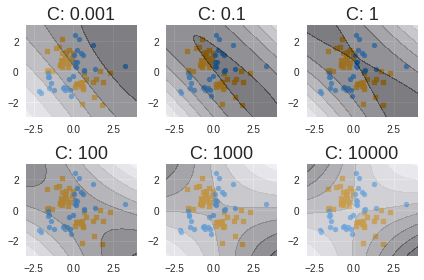

In [12]:
X, y = afx.svm_logical_xor_data(nsize=75)
afx.svm_c_hyperparameter(X, y, c_range=[0.001, 0.1, 1, 100, 1000, 10000])

### Gamma

$\gamma$ es el parámetro que controla el __ancho del kernel__ cuando es `rbf`. ¿En qué afecta esto? controla la influencia de un punto en específico en la función de decisión. La figura creada con `afx.svm_gamma_hyperparameter` evalúa el hiperparámetro en 6 puntos distintos.

Cuando $\gamma$ tiene valores bajos, el kernel RBF tiene un área mayor, impidiendo que el modelo detecte bien cómo varían los puntos. En este escenario el modelo asume que todos los puntos se consideran semejantes entre sí, ignorando las clases. En la medida que $\gamma$ aumenta de valor, el kernel RBF tendrá una mayor sensibilidad a las clases en el conjunto de entrenamiento. De similar manera a los altos valores de C, valores altos en $\gamma$ pueden conducir a overfitting.

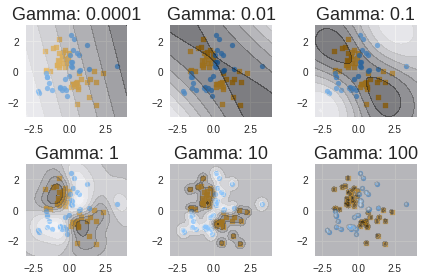

In [13]:
afx.svm_gamma_hyperparameter(X, y, gamma_range=[0.0001, 0.01,0.1, 1, 10, 100])

### ¿Cómo encontramos la mejor combinación de hiperparámetros?

Los modelos SVM necesitan de ambos hiperparámetros mencionados para funcionar adecuadamente. Dado que el costo de la función de decisión está asociado fuertemente con el radio del kernel ($\gamma$). Si imponemos mayores niveles en $\gamma$, necesitaremos que nuestra función de decisión sea menos tolerante con las clasificaciones erróneas, por lo que implementamos C con bajos parámetros. 

Lamentablemente no existen hiperparámetros recomendados por defecto para éstos modelos, por lo que debemos realizar una búsqueda cruzada entre ambos para encontrar un mejor desempeño del modelo. Esta búsqueda cruzada se conoce como _búsqueda de grilla_. Hsu et al (2016) recomiendan implementar una búsqueda de grilla donde cada combinación de hiperparámetros se evalúa mediante validación cruzada. Este procedimiento resulta ser computacionalmente demandante, dado que la cantidad de modelos a estimar es $\textsf{C} \times \gamma \times \textsf{CV}$. Se recomienda partir con un rango amplio de hiperparámetros a evaluar, para reflejar el efecto de un modelo laxo. Siguiendo los consejos de Hsu et al. (2016), se recomiendan rangos $\textsf{C} \in \{2^{-5}, \cdots, 2^{15}\}$ y $\gamma \in \{2^{-15}, \cdots, 2^{3}\}$.

#### Implementación manual de la búsqueda de grilla con validación cruzada

Antes de detallar el procedimiento, cabe destacar que `sklearn` presenta una implementación en el módulo `model_selection` llamada`GridSearchCV` que replica el mismo proceso. Por motivos expositivos, preferimos detallar el procedimiento de manera explícita, evitando esconder ésto en una caja negra. Los pasos para implementar el algoritmo son:

1. Estandarizar los datos con `StandardScaler` o algún otro procesador como `Normalizer` o `MinMaxScaler`.
- Generar conjuntos de entrenamiento y validación con `train_test_split` y preservar la muestra de validación.
- Generamos un loop anidado entre $\textsf{C}$ y $\gamma$.
- Dentro de la anidación, implementamos una validación cruzada del desempeño utilizando `cross_val_score` __en la muestra de entrenamiento__. Se sugiere manejar el rango de validaciones entre 5 y 10.
- La validación cruzada generará una lista con los puntajes para cada iteración. Éstos se preservan en un objeto para posterior uso.

Hay un par de elementos a considerar en este procedimiento. En primer lugar, evitamos realizar la validación cruzada en la muestra completa para no entrenar el modelo con datos que ya tiene conocimiento. Eso es el equivalente a desarrolar una partición en tres, donde tendremos muestras de _entrenamiento_ y _validación_ a iterar (que emergen de nuestro conjunto de entrenamiento). En base a la mejor combinación de hiperparámetros, predecimos los valores frente a los datos de validación __no incorporados en la validación cruzada__. En algunas partes ésta se conoce como un _held-out sample_.

En segundo lugar, cabe destacar que ésta solución no es definitiva. Posteriormente hay que evaluar si el desempeño del modelo es variante, condicional al rango de hiperparámetros. Murphy (2012) entre otros, sugiere que si el desempeño no varía con los hiperparámetros, se puede reasignar el rango hasta que se presente variabilidad en el desempeño.

In [14]:
from sklearn.model_selection import cross_val_score


# Estandarizamos la matriz de atributos
X_scaled = StandardScaler().fit_transform(df.loc[:, 'fixed.acidity':'alcohol'])
# Generamos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['quality_bin'], random_state=11238, test_size=.33)

# rango de C
c_param_range = [1, 10, 100, 1000, 10000, 100000]
# rango de Gamma
gamma_param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

# generamos un diccionario vacío para guardar la combinación
# de hiperparámetros y su desempeño asociado
empty_dict = {}
# capturamos el mejor puntaje
best_score = 0
# iniciamos una lista para capturar la iteración del 1er
# hiperparametro
c_holder = []
# para cada valor en el primer rango
for c in c_param_range:
    # iniciamos una lista para capturar la iteración del
    # 2do parámetro
    gamma_holder = []
    # para cada valor en el segundo rango
    for gamma in gamma_param_range:
        tmp_score = cross_val_score(SVC(C=c, gamma=gamma), 
                    # validamos de forma cruzada con el conjunto de entrenamiento!
                    X_train, y_train, cv=5, n_jobs=-1)
        # generamos una llave col la combinación de parámetros
        # y la lista de desempeño validada de forma cruzada
        empty_dict[str("C: {}, Gamma: {}".format(c, gamma))] = list(tmp_score)
        # Agregamos a cada lista secundaria el promedio de validación cruzada
        gamma_holder.append(np.mean(tmp_score))
        # si la media es mejor que el mejor puntaje registrado
        if np.mean(tmp_score) > best_score:
            best_score = np.mean(tmp_score)
            # extraemos el string asociado a la combinación de valores
            best_params = str("C: {}, Gamma: {}".format(c, gamma))
    # adjuntamos la lista secundaria de cada valor a la primaria.
    c_holder.append(gamma_holder)
# redimensionamos a una matriz
cv_params = np.array(c_holder).reshape(6, 6)

Para visualizar los resultados generaremos dos gráficos. La figura de la izquierda presenta los diagramas de caja para cada una de las validaciones. Éste entrega información sobre qué tanto varía el desempeño en cada una de las iteraciones de la validación cruzada. La figura de la derecha presenta un heatmap con el promedio del desempeño en las cinco iteraciones.

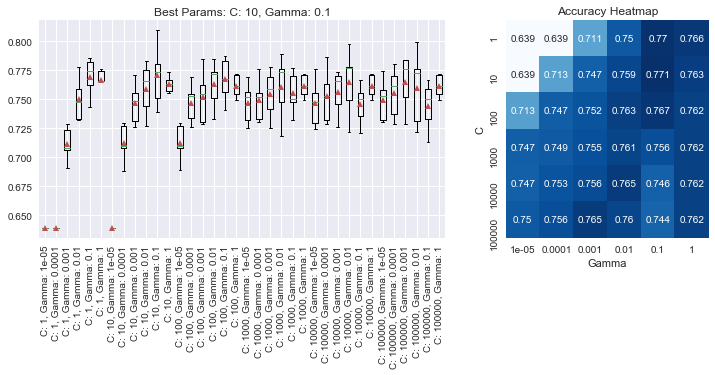

In [23]:
from matplotlib.gridspec import GridSpec
import seaborn as sns

plt.figure(figsize=(12, 4))
# Fijamos tamaños personalizados en el canvas
grid = GridSpec(1, 2, width_ratios=[2,1])
# con el primer espacio del canvas
plt.subplot(grid[0])
# generamos diagramas de caja para cada validación cruzada
# y solicitamos la media
plt.boxplot(empty_dict.values(), showmeans=True);
plt.xticks(range(1, len(empty_dict.keys()) + 1), empty_dict.keys(), rotation=90);
plt.title("Best Params: {}".format(best_params));
# para el segundo espacio del canvas
plt.subplot(grid[1])
# visualizamos el desempeño promedio de cada combinación.
sns.heatmap(cv_params, annot=True, cmap='Blues',
            cbar=False, xticklabels=gamma_param_range, yticklabels=c_param_range, fmt=".3")
plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

Partamos por inspeccionar la figura de los gráficos de caja. Absolutamente todos los clasificadores entrenados presentan un desempeño mejor que un clasificador aleatorio (en este caso $1/2=.5$). Cada uno de los gráficos de caja muestra cual fue la distribución empírica de la exactitud. El título nos informa que la mejor combinación es cuando $\textsf{C}=10, \gamma=0.1$. El heatmap señala que en el caso, la exactitud es del .771.

### Cuarta iteración: entrenamiento del modelo con los mejores hiperparámetros

La figura sugiere que el mejor desempeño de modelo se logra con la combinación de hiperparámetros ($C=10, \gamma=0.1$). Con esta información a mano, ponemos a prueba nuestro clasificador contrastando los puntajes predichos __con la muestra de validación__ que dejamos fuera del procedimiento. Si bien el procedimiento entregó una tasa de exactitud de .771, su desempeño fue de .76. 

In [17]:
from sklearn.metrics import classification_report

refactor_svc_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10, gamma=0.1))
])

wine_svc.fit(X_train, y_train)

best_model = SVC().fit(X_train, y_train)
yhat = best_model.predict(X_test)
print(classification_report(y_test, yhat))

             precision    recall  f1-score   support

          0       0.68      0.45      0.54       815
          1       0.72      0.87      0.79      1330

avg / total       0.71      0.71      0.70      2145



Un aspecto a considerar es que éste nuevo modelo presenta un mejor desempeño para identificar los vinos con un valor menor a la media. En comparación al primer modelo que generamos, donde el recall y precisión eran de .56 y .70, con esta nueva iteración mejoramos en .6 y .3 puntos porcentuales respectivamente.

¿Qué puede explicar este estancamiento en el desempeño del modelo? Existe una serie de factores que están asociados con la distribución de nuestro vector objetivo:
1. Binarización forzada: Quizás una de las primeras piedras de tope es la decisión de binarizar nuestro vector objetivo en base a si la observación era mayor o menor a la media. Esto genera que eliminemos variabilidad de nuestro estudio. Éste fenómeno se conoce como _binning_.
- Desbalance de clases: Quizás otro de los factores que afecta el desempeño del modelo es la existencia de más vinos buenos que malos en la muestra. Una alternativa para este caso es *a)* Obtener más datos para entrenar el modelo, *b)* Generar oversampling sintético en la categoría con menos casos.

In [18]:
df['quality_bin'].value_counts('%')

1    0.633061
0    0.366939
Name: quality_bin, dtype: float64

## Consideraciones

Para cerrar esta lectura, presentamos una serie de aspectos adicionales que se pueden considerar.

### Problemas donde $\mathbb{Y} \geq 2$

Originalmente las máquinas de soporte vectorial fueron diseñadas para generar clasificaciones en casos binarios. Hsu y Lin (2002) consideran que para extenderlas en más clases es un área que todavía está en desarrollo. A grandes rasgos, las clasificaciones multiclases con SVM se basan mediante la combinación de múltiples subclasificadores posibles:

* _One-against-all_: bajo esta estrategia se generan tantos subclasificadores como clases existentes en el vector objetivo. En base a cada subclasificador se extrae una función de decisión y posteriormente se elige aquella que maximize el valor.
* _One-against-one_: bajo esta estrategia se generan $k(k-1)/2$ subclasificadores, donde $k$ es la cantidad de clases en el vector objetivo. En base a cada subclasificador, se implementa una estrategia de votación simple para cada una de las observaciones.

Ambas estrategias se implementan en `SVC` al modificar la opción `decision_function_shape`. Por defecto la opción es `'ovr'` que corresponde a la estrategia _one-against-all_. Para implementar la estrategia _one-against-one_ con la opción `'ovo'`. Dado que una de las principales limitantes es el hecho que si nuestro vector objetivo tiene un alto número de categorías (dígase 10), el tiempo de ejecución del algoritmo puede ser prohibitivo.


### SVM en regresión

Las Máquinas de Soporte Vectorial también se pueden implementar para problemas de regresión. Para este tipo de tarea buscamos predecir un valor real de $y$ de forma tal que para toda observación $x_{i}$ tengamos un $y_{i}$ correspondiente. El algoritmo busca un $y$ que minimice una función de error candidata. De similar manera, buscamos desarrollar un márgen dado por $\varepsilon$. Este modelo se conoce como regresión $\varepsilon$-insensible. Esto genera una regresión robusta frente a los residuales. Berk (2008) señala que hasta el momento no hay una ventaja comparativa clara entre la regresión $\varepsilon$-insensible y otras formas de regresión robusta.

### Puntos a favor

- Son efectivas en espacios de altas dimensiones.
- Son relativamente eficientes cuando la cantidad de dimensiones es mayor a la cantidad de observaciones.
- Es eficientes en términos de memoria porque utiliza un subconjunto de datos de entrenamiento para generar la función de decisión.

### Puntos en contra

- SVM no se pensó en capturar la función generadora en los atributos, por lo que es difícil identificar el impacto de los atributos en nuestro vector objetivo. SVM pertenencen a un grupo de algoritmos conocidos como _modelos de caja negra_, dado que no entregan mucha información sobre cómo se llega a cierto resultado. Esto en oposición a los métodos basados en regresión.


# Referencias

* Berk, Richard A. 2008. Statistical learning from a regression perspective. Vol. 14. New York: Springer.
* Cortes, C; Vapnik, V. 1995. Support-Vector Networks. Machine Learning 20. pp: 273-297.
* Hastie, T; Tibshirani, T; Friedman, J. 2008. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch12: Support Vector Machines and Flexible Discriminants.
* Hsu, Chih-Wei, and Chih-Jen Lin. 2002. A comparison of methods for multiclass support vector machines. IEEE transactions on Neural Networks 13, no. 2: 415-425.
* Hsu, Chih-Wei, Chih-Chung Chang, and Chih-Jen Lin. 2016. A practical guide to support vector classification. 1-16.
* Murphy. K. 2012. Machine Learning. A Probabilistic Perspective, Cambridge, MA: Massachusetts Institute of Technology Press. Ch14: Kernels. 14.4: The Kernel Trick. 14.5: Support Vector Machines.